In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from score_analysis import showbias
from score_analysis.showbias_plotting import (
    plot_multiple_thresholds,
    plot_single_threshold,
)

rng = np.random.default_rng()

## Create some toy data

In its simplest case, the showbias function assumes that you have a pandas dataframe with three columns:
- a `group` column that indicates group membership for every row, e.g. female and male values in a column called gender
- a `scores` column that contains the predicted scores (e.g. by a model) for
- a `labels` column that contains the ground truth using integers

Below we create a synthetic dataset that contains dogfido<b><sup>TM</sup></b> IDV data for different dog breeds

In [2]:
dog_breeds = ["German Shepherd", "Golden Retriever", "Bulldog", "Beagle"]
genders = ["male", "female"]
n = 1_000

df = pd.DataFrame(
    {
        "breed": rng.choice(dog_breeds, size=n),
        "gender": rng.choice(genders, size=n),
        "labels": rng.choice([0, 1], size=n),
        "scores": rng.uniform(0.0, 1.0, size=n),
    }
)

In [3]:
df.head()

,breed,gender,labels,scores
0,Bulldog,male,1,0.459373
1,Bulldog,female,1,0.739913
2,Beagle,male,1,0.828785
3,Golden Retriever,female,0,0.895087
4,Bulldog,female,0,0.189259


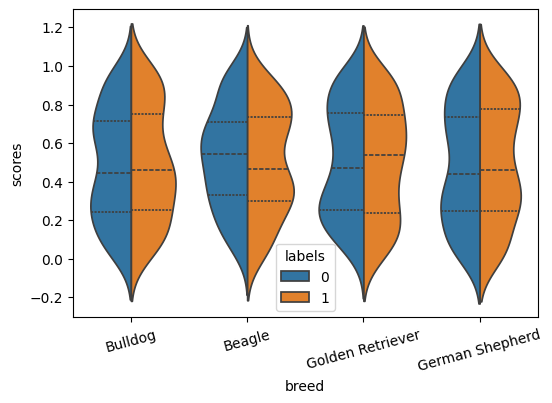

In [4]:
plt.figure(figsize=(6, 4))
sns.violinplot(data=df, x="breed", y="scores", hue="labels", split=True, inner="quart")
plt.xticks(rotation=15)
plt.show()

## Showbias vanilla version

In [5]:
bias_frame = showbias(
    data=df,
    group_columns=["breed", "gender"],
    label_column="labels",
    score_column="scores",
    metric="fnr",
    threshold=[0.5],
)

In [6]:
bias_frame.values

0.5
breed            gender          
Beagle           female  0.454545
                 male    0.576923
Bulldog          female  0.600000
                 male    0.482143
German Shepherd  female  0.513514
                 male    0.517857
Golden Retriever female  0.492754
                 male    0.432836

## Passing several thresholds at once

In [7]:
bias_frame = showbias(
    data=df,
    group_columns=["breed", "gender"],
    label_column="labels",
    score_column="scores",
    metric="fnr",
    threshold=[0.3, 0.5, 0.7],
)
bias_frame.values

0.3       0.5       0.7
breed            gender                              
Beagle           female  0.272727  0.454545  0.618182
                 male    0.230769  0.576923  0.769231
Bulldog          female  0.338462  0.600000  0.753846
                 male    0.267857  0.482143  0.625000
German Shepherd  female  0.270270  0.513514  0.675676
                 male    0.357143  0.517857  0.642857
Golden Retriever female  0.304348  0.492754  0.724638
                 male    0.298507  0.432836  0.656716

## Normalizing metric

You can obtain metrics that are normalized to the metric measured across the entire dataset by passing the `normalize` argument, like so:

In [8]:
bias_frame = showbias(
    data=df,
    group_columns=["breed", "gender"],
    label_column="labels",
    score_column="scores",
    metric="fnr",
    threshold=[0.5],
    normalize="by_overall",
)
bias_frame.values

0.5
breed            gender          
Beagle           female  0.894603
                 male    1.135458
Bulldog          female  1.180876
                 male    0.948919
German Shepherd  female  1.010660
                 male    1.019209
Golden Retriever female  0.969802
                 male    0.851876

## What is a BiasFrame?

In [9]:
type(bias_frame)

score_analysis.showbias.BiasFrame

In [10]:
print(bias_frame)

BiasFrame(values=                              0.5
breed            gender          
Beagle           female  0.894603
                 male    1.135458
Bulldog          female  1.180876
                 male    0.948919
German Shepherd  female  1.010660
                 male    1.019209
Golden Retriever female  0.969802
                 male    0.851876, alpha=None, lower=None, upper=None)


In [11]:
type(bias_frame.values)

pandas.core.frame.DataFrame

## Confidence intervals

You can obtain confidence intervals by setting the `bootstrap_ci` to `True`:

In [12]:
bias_frame = showbias(
    data=df,
    group_columns=["breed", "gender"],
    label_column="labels",
    score_column="scores",
    metric="fnr",
    threshold=[0.5],
    bootstrap_ci=True,
)

In [13]:
bias_frame.values

0.5
breed            gender          
Beagle           female  0.454545
                 male    0.576923
Bulldog          female  0.600000
                 male    0.482143
German Shepherd  female  0.513514
                 male    0.517857
Golden Retriever female  0.492754
                 male    0.432836

In [14]:
bias_frame.lower

0.5
breed            gender          
Beagle           female  0.339623
                 male    0.428571
Bulldog          female  0.483871
                 male    0.348032
German Shepherd  female  0.402566
                 male    0.400000
Golden Retriever female  0.372831
                 male    0.318182

In [15]:
bias_frame.upper

0.5
breed            gender          
Beagle           female  0.592197
                 male    0.698113
Bulldog          female  0.723214
                 male    0.609865
German Shepherd  female  0.633108
                 male    0.645161
Golden Retriever female  0.615260
                 male    0.559504

In [16]:
print(bias_frame.to_markdown())

|                                | 0.5             |
|:-------------------------------|:----------------|
| ('Beagle', 'female')           | 0.455           |
|                                | (0.34 - 0.592)  |
| ('Beagle', 'male')             | 0.577           |
|                                | (0.429 - 0.698) |
| ('Bulldog', 'female')          | 0.6             |
|                                | (0.484 - 0.723) |
| ('Bulldog', 'male')            | 0.482           |
|                                | (0.348 - 0.61)  |
| ('German Shepherd', 'female')  | 0.514           |
|                                | (0.403 - 0.633) |
| ('German Shepherd', 'male')    | 0.518           |
|                                | (0.4 - 0.645)   |
| ('Golden Retriever', 'female') | 0.493           |
|                                | (0.373 - 0.615) |
| ('Golden Retriever', 'male')   | 0.433           |
|                                | (0.318 - 0.56)  |


## BiasFrame methods

### to_markdown()

In [17]:
bias_frame_md = bias_frame.to_markdown(
    reset_display_index=True, number_decimal_points=5
)
print(bias_frame_md)

| breed            | gender   | 0.5                 |
|:-----------------|:---------|:--------------------|
| Beagle           | female   | 0.45455             |
|                  |          | (0.33962 - 0.5922)  |
| Beagle           | male     | 0.57692             |
|                  |          | (0.42857 - 0.69811) |
| Bulldog          | female   | 0.6                 |
|                  |          | (0.48387 - 0.72321) |
| Bulldog          | male     | 0.48214             |
|                  |          | (0.34803 - 0.60986) |
| German Shepherd  | female   | 0.51351             |
|                  |          | (0.40257 - 0.63311) |
| German Shepherd  | male     | 0.51786             |
|                  |          | (0.4 - 0.64516)     |
| Golden Retriever | female   | 0.49275             |
|                  |          | (0.37283 - 0.61526) |
| Golden Retriever | male     | 0.43284             |
|                  |          | (0.31818 - 0.5595)  |


## Plotting functionality

### plot_single_threshold

In [18]:
dog_breeds = ["German Shepherd", "Golden Retriever", "Bulldog", "Beagle"]
n = 1_000

df = pd.DataFrame(
    {
        "breed": rng.choice(dog_breeds, size=n),
        "labels": rng.choice([0, 1], size=n),
        "scores": rng.uniform(0.0, 1.0, size=n),
    }
)

bias_frame = showbias(
    data=df,
    group_columns="breed",
    label_column="labels",
    score_column="scores",
    metric="fnr",
    threshold=[0.5],
    bootstrap_ci=True,
)

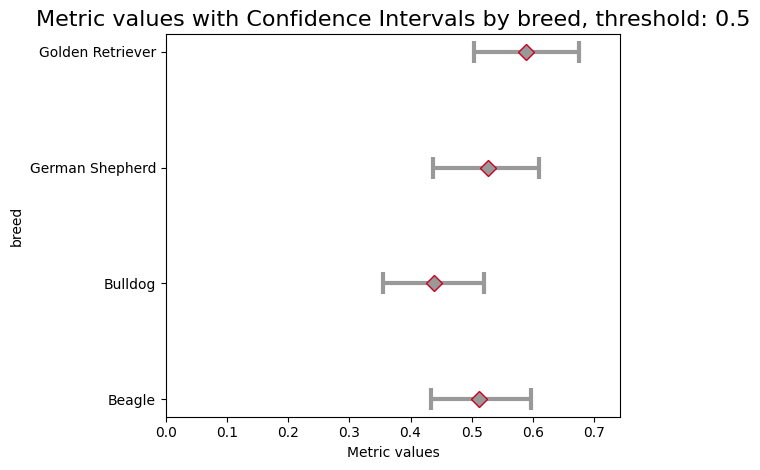

In [19]:
plot = plot_single_threshold(bias_frame, threshold=0.5)

### plot_multiple_thresholds

In [20]:
bias_frame = showbias(
    data=df,
    group_columns="breed",
    label_column="labels",
    score_column="scores",
    metric="fnr",
    threshold=np.linspace(0.0, 1.0, 1000),
)

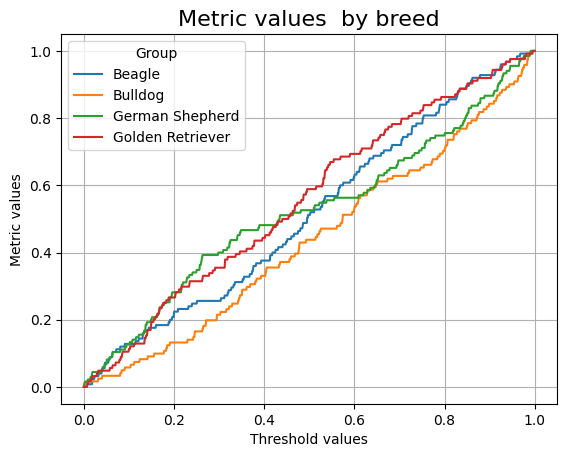

In [21]:
plot = plot_multiple_thresholds(bias_frame)

## Available metrics

`showbias` supports all metrics that are supported by `score-analysis`.
Currently, you can pass any of the strings below to the metric argument in showbias:

Basic parameters:
- "tp" (true positive)
- "tn" (true negative)
- "fp" (false positive)
- "fn" (false negative)
- "p" (condition positive)
- "n" (condition negative)
- "top" (test outcome positive)
- "ton" (test outcome negative)
- "pop" (population counts)

Class metrics
- "tpr" (true positive rate)
- "tnr" (true negative rate)
- "fpr" (false positive rate)
- "fnr" (false negative rate)
- "topr" (test outcome positive rate)
- "tonr" (test outcome negative rate)
- "ppv" (positive predictive value)
- "npv" (negative predictive value)
- "fdr" (false discovery rate)
- "for_" (false omission rate)
- "class_accuracy" (class accuracy)
- "class_error_rate" (class_error_rate)

Overall metrics
- "accuracy" (Accuracy)
- "error_rate" (Error rate)